In [424]:
# prompt: mount drive
import os
import pandas as pd
import re
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import cmath

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria


In [409]:
path_silicio = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/Si_445"
path_vidrio = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/vidrio_2"

# Funciones

In [378]:
def arctan3(y,x):
  return np.mod(np.arctan2(y,x),2*np.pi)-5/4*np.pi

In [379]:
def psi_delta_teorico(LongitudOnda, n0, n1, n2, d, angulo_incial = 15, angulo_final = 80, angulo_paso = 0.5):

  #Unidad compleja
  i = complex(0,1)

  #Angulo de incidencia
  theta_0 = np.arange(angulo_incial, angulo_final, angulo_paso)
  theta_0 = np.array(theta_0).astype(np.float32) * np.pi / 180

  #Angulos de refracción y transmisión
  sin_theta_0 = np.sin(theta_0)
  cos_theta_0 = np.cos(theta_0)
  sin_theta_1 = (n0/n1) * sin_theta_0
  cos_theta_1 = np.sqrt(1 - sin_theta_1**2)
  sin_theta_2 = (n0/n2) * sin_theta_0
  cos_theta_2 = np.sqrt(1 - sin_theta_2**2)

  #Diferencia de fases
  beta = 2*np.pi/LongitudOnda*d*n1*cos_theta_1

  #Indices de Reflectancia paralelo y perpendicular
  r01p = (n1*cos_theta_0 - n0*cos_theta_1) / (n1*cos_theta_0 + n0*cos_theta_1)
  r01s = (n0*cos_theta_0 - n1*cos_theta_1) / (n0*cos_theta_0 + n1*cos_theta_1)
  r12p = (n2*cos_theta_1 - n1*cos_theta_2) / (n2*cos_theta_1 + n1*cos_theta_2)
  r12s = (n1*cos_theta_1 - n2*cos_theta_2) / (n1*cos_theta_1 + n2*cos_theta_2)

  #Reflectancia total paralela y perpendicular
  r012p = (r01p + r12p*np.exp(-2*i*beta)) / (1 + r01p*r12p*np.exp(-2*i*beta))
  r012s = (r01s + r12s*np.exp(-2*i*beta)) / (1 + r01s*r12s*np.exp(-2*i*beta))

  #Ley de Elipsometría
  P = r012p/r012s

  # Módulo y fase de P
  modulo_P = np.abs(P)
  fase_P = np.angle(P)

  # Definir delta y psi
  delta = fase_P
  delta[delta < 0] = -delta[delta < 0]
  psi = np.arctan(modulo_P)

  #Pasa a grados
  psi = psi * 180 / np.pi
  delta = delta * 180 / np.pi
  theta_0 = theta_0 * 180 / np.pi

  return psi, delta, theta_0

In [380]:
def calibracion_intensidades(I0, I45, I90, I135, angulo_calibracion):
  #Stokes
  S0 = I0 + I90
  S1 = I0 - I90
  S2 = I45 - I135

  #Stokes calibrado
  S1_rot = np.cos(2*angulo_calibracion) * S1 + np.sin(2*angulo_calibracion) * S2
  S2_rot = -np.sin(2*angulo_calibracion) * S1 + np.cos(2*angulo_calibracion) * S2

  #Intensidades
  I0 = 0.5*(S0 + S1_rot)
  I45 = 0.5*(S0 + S2_rot)
  I90 = 0.5*(S0 - S1_rot)
  I135 = 0.5*(S0 - S2_rot)

  return I0, I45, I90, I135

In [381]:
def crear_lista_angulos(angulo_incial, angulo_final, angulo_paso):
  #Angulos de incidencia
  theta_0_str = []
  num = float(angulo_incial)
  while num <= angulo_final:
    if num.is_integer():
      theta_0_str.append(str(int(num)))
    else:
      theta_0_str.append(str(num))
    num += angulo_paso
  return theta_0_str

In [382]:
def obtener_muestra(wavelength, LongitudOnda):
  #Longitud de onda a nm
  LongitudOnda = LongitudOnda * 1e9

  # Find the index of the closest value to 450
  closest_index = np.argmin(np.abs(wavelength - LongitudOnda))

  # Get the value at the closest index
  closest_value = wavelength[closest_index]

  #Longitud de Onda muestra
  N = np.where(wavelength == closest_value)[0][0]

  return N

In [383]:
def calculo_psi_delta_experimental(I0, I45, I90, I135, dataset, theta, LongitudOnda, saturar):

  #Eje horizontal
  wavelength = np.array(dataset[theta]['wavelength'])

  #Obtener número de muestra
  N = obtener_muestra(wavelength, LongitudOnda)

  #Psi
  psi = 0.5*np.arccos((I90[:,N]-I0[:,N])/(I90[:,N]+I0[:,N]))

  #Delta
  argumento = ((I45[:,N]-I135[:,N])/(I45[:,N]+I135[:,N])) / np.sin(2*psi)

  #Valores fuera de rango
  if saturar:
    argumento[argumento < -1] = -1
    argumento[argumento > 1] = 1

  delta = np.arccos(argumento)

  return psi, delta

In [384]:
def psi_delta_experimental(dataset, LongitudOnda, angulo_incial, angulo_final, angulo_paso, angulo_calibracion = 0, saturar = False):

  #Calibración
  ang_cal = angulo_calibracion * np.pi / 180

  #Lista de ángulos
  theta_0_str = crear_lista_angulos(angulo_incial, angulo_final, angulo_paso)

  #Angulos de polarización
  angulos = ['0', '45', '90', '135']

  for i, theta in enumerate(theta_0_str):
    if i == 0:
      #Intensidades
      I0 = dataset[theta]['transmitance 0']
      I45 = dataset[theta]['transmitance 45']
      I90 = dataset[theta]['transmitance 90']
      I135 = dataset[theta]['transmitance 135']

      #Calibración de intensidades
      I0, I45, I90, I135 = calibracion_intensidades(I0, I45, I90, I135, ang_cal)

    else:
      #Intensidades
      I0_new = dataset[theta]['transmitance 0']
      I45_new = dataset[theta]['transmitance 45']
      I90_new = dataset[theta]['transmitance 90']
      I135_new = dataset[theta]['transmitance 135']

      #Calibración de intensidades
      I0_new, I45_new, I90_new, I135_new = calibracion_intensidades(I0_new, I45_new, I90_new, I135_new, ang_cal)

      #Intensidades
      I0 = np.vstack((I0, I0_new))
      I45 = np.vstack((I45, I45_new))
      I90 = np.vstack((I90, I90_new))
      I135 = np.vstack((I135, I135_new))

  #Calculo psi, Delta
  psi, delta = calculo_psi_delta_experimental(I0, I45, I90, I135, dataset, theta, LongitudOnda, saturar = saturar)

  #Calibración
  psi = psi - ang_cal

  #Pasa a grados
  psi = psi / np.pi * 180
  delta = delta / np.pi * 180
  theta_0 = np.array(theta_0_str).astype(float)

  return psi, delta, theta_0

In [425]:
def crear_dataset(path, verbose = False):

  #Dataset donde se guardará toda la información
  dataset = {}

  #cd Path
  os.chdir(path)

  #Lista de carpetas, cada una representando un ángulo del brazo
  folders = os.listdir(path)

  #Recorrer carpetas
  for folder in folders:

    #Unir rutas para acceder dentro de la carpeta ángulo del brazo
    folder_path = os.path.join(path, folder)

    #Recorrer archivos, cada uno representando un ángulo del analizador
    txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

    if os.path.isdir(folder_path):

      for i, file in enumerate(txt_files):

        #Imprimir Nombres
        if verbose:
          print(folder_path)
          print(file)

        #Abrir Archivo sólo donde interesa
        with open(folder + '/' + file, 'r') as f:
          lines = f.readlines()

          data_start = lines.index(">>>>>Begin Processed Spectral Data<<<<<\n") + 1
          data_end = lines.index(">>>>>End Processed Spectral Data<<<<<\n")

          data_lines = lines[data_start:data_end]

        # Extraer exposición
        line = next(line for line in lines if "Integration Time (usec):" in line)
        integration_time_str = re.search(r"Integration Time \(usec\): (\d+)\s*\(ADUD7991\)\n", line).group(1)
        integration_time = int(integration_time_str)

        #Imprimir Tiempo de Integración
        if verbose:
          print("Integration Time (usec): ", integration_time)

        # Separar en dos columnas los datos
        wavelength, transmitance = [], []
        for line in data_lines:
          values = line.split('\t')
          wavelength.append(float(values[0]))
          transmitance.append(float(values[1]))

        #Agregar al dataset el conjunto de medidas
        df = pd.DataFrame({
            'wavelength': wavelength,
            'transmitance ' + file[:-4]: np.array(transmitance)/integration_time
        })

        #Si es el primero, copia el dataset
        if i == 0:
          dataset[folder] = df

        #Sino, agrega las demas transmitancias
        else:
          dataset[folder]['transmitance ' + file[:-4]] = df['transmitance ' + file[:-4]]

        if verbose:
          print('\n')

  return dataset

In [453]:
def mostrar_dataset(dataset, theta, angulo_calibracion = 0):

  #Tomar dato de ángulo brazo theta
  data = dataset[theta]

  #Intensidades
  I0 =  data['transmitance 0']
  I45 = data['transmitance 45']
  I90 =  data['transmitance 90']
  I135 = data['transmitance 135']

  #Stokes
  S0 = I0 + I90
  S1 = I0 - I90
  S2 = I45 - I135

  #Angulo de Calibración
  ang_cal = angulo_calibracion * np.pi/180

  #Stokes calibrado
  S1_rot = np.cos(2*ang_cal) * S1 + np.sin(2*ang_cal) * S2
  S2_rot = -np.sin(2*ang_cal) * S1 + np.cos(2*ang_cal) * S2

  #Intensidades rotadas
  I0 = 0.5*(S0 + S1_rot)
  I45 = 0.5*(S0 + S2_rot)
  I90 = 0.5*(S0 - S1_rot)
  I135 = 0.5*(S0 - S2_rot)

  #Vector de Intensidades
  I = [I0, I45, I90, I135]

  #DoLP y AoLP
  DoLP = np.divide(np.sqrt(np.power(S1_rot.astype(float),2) + np.power(S2_rot.astype(float),2)), S0, out = np.zeros_like(S0.astype(float)), where = S0!= 0)
  AoLP = 0.5*arctan3(S2_rot.astype(float), S1_rot.astype(float))

  #Eje horizontal
  wavelength = data['wavelength']

  #Crear Figura
  fig, axes = plt.subplots(2, 2, figsize=(7, 7))

  #Mostrar cada espectro polarizado
  angulos = ['0', '45', '90', '135']

  #Limite Ylim
  Ylim = 0
  for i, angulo in enumerate(angulos):
    Ylim = max(Ylim, np.max(I[i]))

   # Plot the data in the subplot
  for i, angulo in enumerate(angulos):
    axes[i // 2, i % 2].plot(wavelength, I[i]/Ylim)
    axes[i // 2, i % 2].set_xlabel('Wavelength (nm)')
    axes[i // 2, i % 2].set_ylabel('Transmitancia')
    axes[i // 2, i % 2].set_title('Ángulo Analizador = ' + angulo + 'º')
    axes[i // 2, i % 2].set_ylim(0, 1)

  # Adjust spacing and display
  plt.tight_layout()
  plt.show()

  #Figuras
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  #DoLP
  axes[0].plot(data['wavelength'], DoLP)
  axes[0].set_xlabel('Longitud de Onda (nm)')
  axes[0].set_ylabel('Grado de Polarización Lineal')
  axes[0].set_xlim(400, 900)
  axes[0].set_ylim(0, 2)
  axes[0].axhline(y=1, color='k', linestyle='--', linewidth=1)
  axes[0].axhline(y=1+0.05, color='r', linestyle='--', linewidth=1)
  axes[0].axhline(y=1-0.05, color='r', linestyle='--', linewidth=1)
  axes[0].set_title('Espectro DoLP')

  #AoLP
  axes[1].plot(data['wavelength'], AoLP)
  axes[1].set_xlabel('Longitud de Onda (nm)')
  axes[1].set_ylabel('Ángulo de Polarización Lineal')
  axes[1].set_xlim(400, 900)
  axes[1].set_ylim(0, 2*np.pi)
  axes[1].set_title('Espectro AoLP')

  #0
  axes[1].axhline(y=0/4*np.pi, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=0/4*np.pi+np.pi*0.05, color='r', linestyle='--', linewidth=1)

  #45
  axes[1].axhline(y=1/4*np.pi, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=1/4*np.pi+np.pi*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=1/4*np.pi-np.pi*0.05, color='r', linestyle='--', linewidth=1)

  #90
  axes[1].axhline(y=2/4*np.pi, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=2/4*np.pi+np.pi*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=2/4*np.pi-np.pi*0.05, color='r', linestyle='--', linewidth=1)

  #135
  axes[1].axhline(y=3/4*np.pi, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=3/4*np.pi+np.pi*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=3/4*np.pi-np.pi*0.05, color='r', linestyle='--', linewidth=1)

  #180
  axes[1].axhline(y=4/4*np.pi, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=4/4*np.pi+np.pi*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=4/4*np.pi-np.pi*0.05, color='r', linestyle='--', linewidth=1)

  # Adjust spacing and display
  plt.tight_layout()
  plt.show()

  #DoLP y AoLP en 500 nm
  N = obtener_muestra(data['wavelength'], 550e-9)
  print('\nDatos a 550 nm: ')
  print('DoLP: ', DoLP[N])
  print('AoLP: ', AoLP[N] * 180 / np.pi)

# Silicio 445

In [454]:
dataset_silicio = crear_dataset(path_silicio)

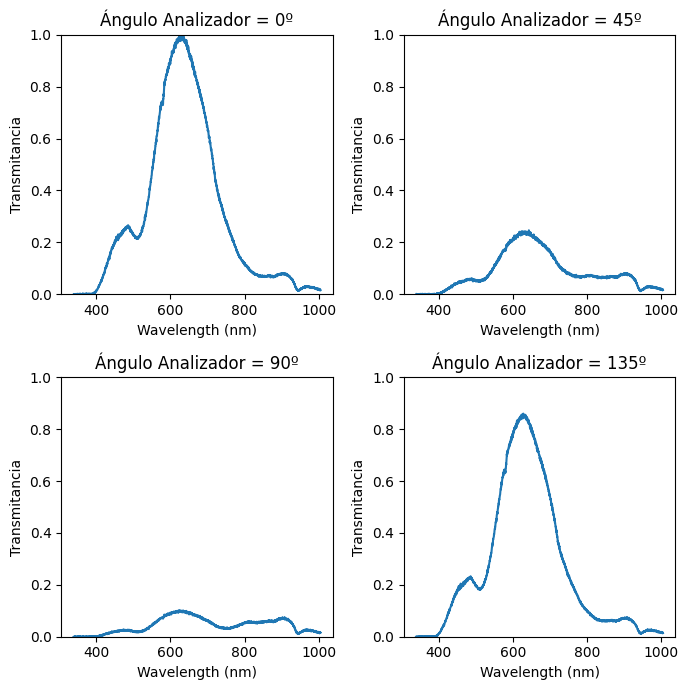

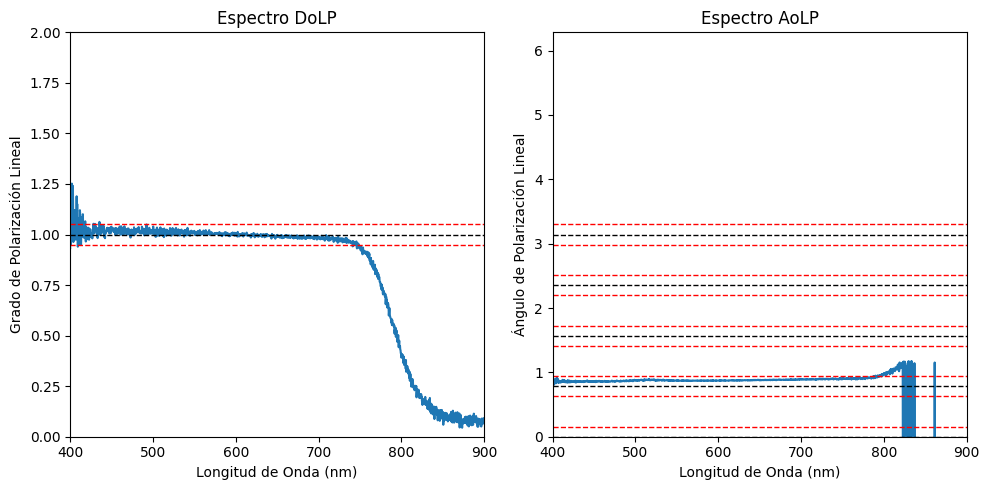


Datos a 550 nm: 
DoLP:  1.0179807412721877
AoLP:  50.154294789208635


In [455]:
mostrar_dataset(dataset_silicio, '15')

# Vidrio 2

In [451]:
dataset_vidrio = crear_dataset(path_vidrio)

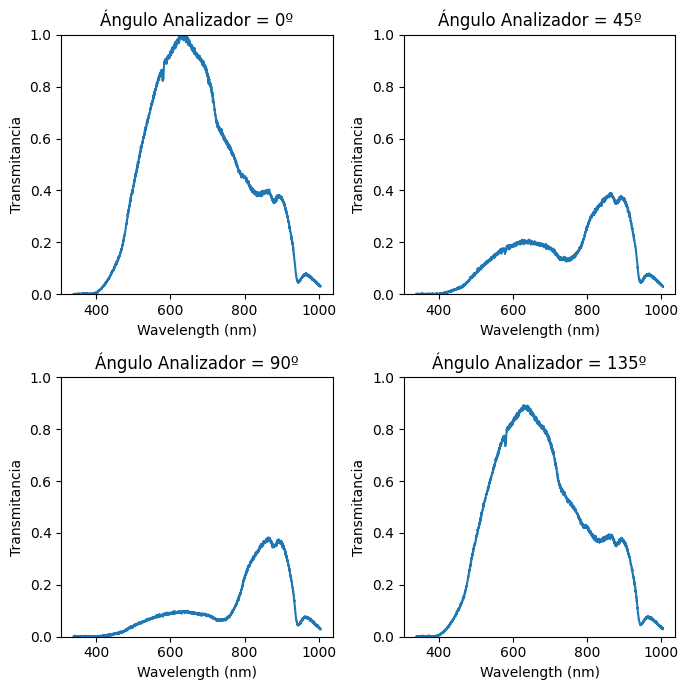

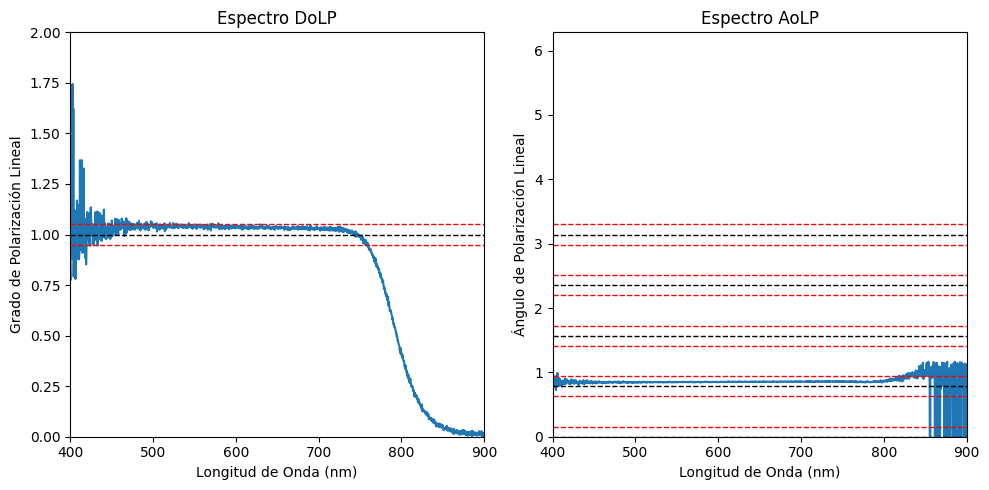


Datos a 550 nm: 
DoLP:  0.07710579232757893
AoLP:  35.78252558853897


In [452]:
mostrar_dataset(dataset_vidrio, '15')

# Curvas Δ, Ψ

In [475]:
#Parámetros Silicio
n0 = 1
n1 = 1.46
n2 = 4.3
LongitudOnda = 500 * 1e-9
d = 445 * 1e-9
angulo_paso = 2.5
dataset = dataset_silicio

In [436]:
#Parámetros Vidrio
n0 = 1
n1 = 1.52
n2 = 1
LongitudOnda = 500 * 1e-9
d = 1 * 1e-3
angulo_paso = 5
dataset = dataset_vidrio

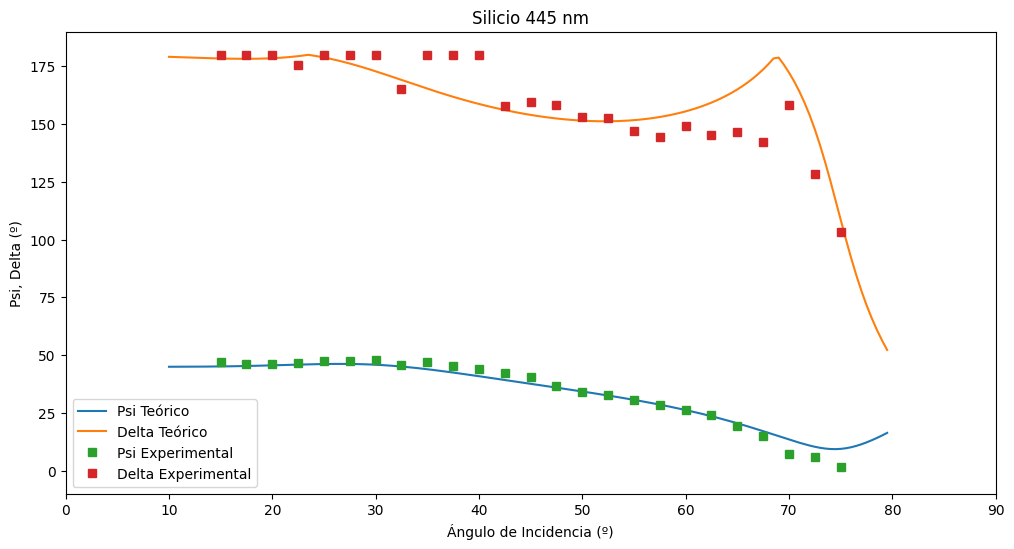

In [483]:
#Calculo Experimental
psi_experimental, delta_experimental, theta_0_experimental = psi_delta_experimental(dataset, LongitudOnda, angulo_incial = 15, angulo_final = 75, angulo_paso = angulo_paso, angulo_calibracion = 13, saturar = True)

#Calculo teórico
psi_teorico, delta_teorico, theta_0_teorico = psi_delta_teorico(LongitudOnda, n0, n1, n2, d, angulo_incial = 10, angulo_final = 80, angulo_paso = 0.5)

# Plot psi and delta in degrees
plt.figure(figsize=(12, 6))
plt.plot(theta_0_teorico, psi_teorico, '', label = 'Psi Teórico')
plt.plot(theta_0_teorico, delta_teorico , '', label = 'Delta Teórico')
plt.plot(theta_0_experimental, psi_experimental, 's', label = 'Psi Experimental')
plt.plot(theta_0_experimental, delta_experimental, 's', label = 'Delta Experimental')
plt.xlabel('Ángulo de Incidencia (º)')
plt.ylabel('Psi, Delta (º)')
plt.title('Silicio 445 nm')
plt.xlim([0, 90])
plt.ylim([-10, 190])
plt.legend()
plt.show()

In [466]:
#Parámetros Silicio
n0 = 1
n1 = 1.46
n2 = 4.3
LongitudOnda = 500 * 1e-9
d = 600 * 1e-9
angulo_paso = 2.5
dataset = dataset_silicio

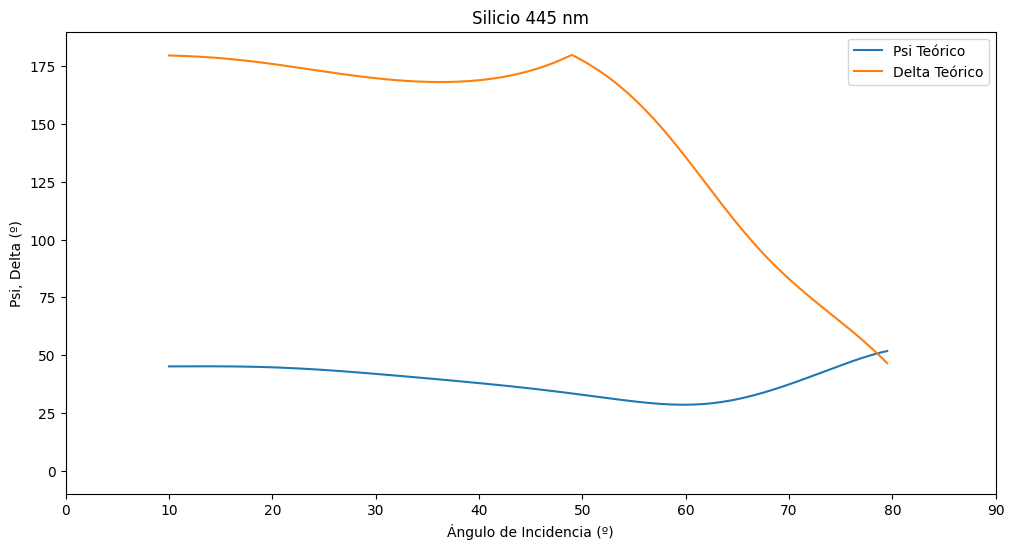

In [467]:
#Calculo teórico
psi_teorico, delta_teorico, theta_0_teorico = psi_delta_teorico(LongitudOnda, n0, n1, n2, d, angulo_incial = 10, angulo_final = 80, angulo_paso = 0.5)

# Plot psi and delta in degrees
plt.figure(figsize=(12, 6))
plt.plot(theta_0_teorico, psi_teorico, '', label = 'Psi Teórico')
plt.plot(theta_0_teorico, delta_teorico , '', label = 'Delta Teórico')
plt.xlabel('Ángulo de Incidencia (º)')
plt.ylabel('Psi, Delta (º)')
plt.title('Silicio 445 nm')
plt.xlim([0, 90])
plt.ylim([-10, 190])
plt.legend()
plt.show()